In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
#from torchvision import transforms
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model

In [2]:
plt.style.use('Solarize_Light2')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/model.py'>

In [3]:
W = H = 256

BATCH_SIZE = 100

LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [4]:
def show(image, labels):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ""
    npimage = image.numpy()
    nplabels = labels.numpy()
    print(npimage.shape)
    print(nplabels)

    for i, label in enumerate(nplabels):
        if label == 1:
            if title == '':
                title += LABEL_NAMES_MAP[i]
            else:
                title += " & " + LABEL_NAMES_MAP[i]
    
    ax1.imshow(npimage[0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(npimage[1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(npimage[2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(npimage[3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)
    

In [5]:
class HPA_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HPA_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(16 * W/4 * H/4), 900)
        self.out2 = nn.Linear(900, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output

In [6]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)

    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [7]:
def test(model, validation_loader, validation_dataset_size, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        total = 0.0
        
        for inputs, labels in validation_loader:
            inputs = inputs.to(device, dtype=torch.float)
            
            labels = labels.to(device, dtype=torch.uint8)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            total += labels.size(0)

            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        print("total: ", total)
        accuracy = correct_predicted_total / total
        print(
                "Validation accuracy of the model on the {} validation images: {} ".format(
                    validation_dataset_size,
                    accuracy
                )
            )

    return accuracy

In [8]:
def validate(model, validation_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        #total = 0.0
        
        for inputs, labels in validation_loader:
            inputs = inputs.to(device, dtype=torch.float)
            
            labels = labels.to(device, dtype=torch.uint8)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            #total += labels.size(0)
            labels = labels.data.byte()
            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        #accuracy = correct_predicted_total / total
        accuracy = correct_predicted_total
        

    return (total_loss, accuracy)

In [9]:
train_df = load_data.load_text_data('../input/train.csv')

In [10]:
print(train_df.shape)

(31072, 2)


In [11]:
dataset = load_data.HumanProteinAtlasDataset(
    train_df,
    transform=load_data.transforms.ToTensor()
)

In [12]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  31072
validation_subset_size:  12428


In [13]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [14]:
print(train_dataset_size)
print(validation_dataset_size)

18644
12428


In [15]:
print(train_loader)

In [16]:
train_iter = iter(train_loader)

In [17]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [18]:
images, labels = train_iter.next()

In [19]:
print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([100, 4, 256, 256])
labels shape on batch size = torch.Size([100, 28])


(4, 256, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


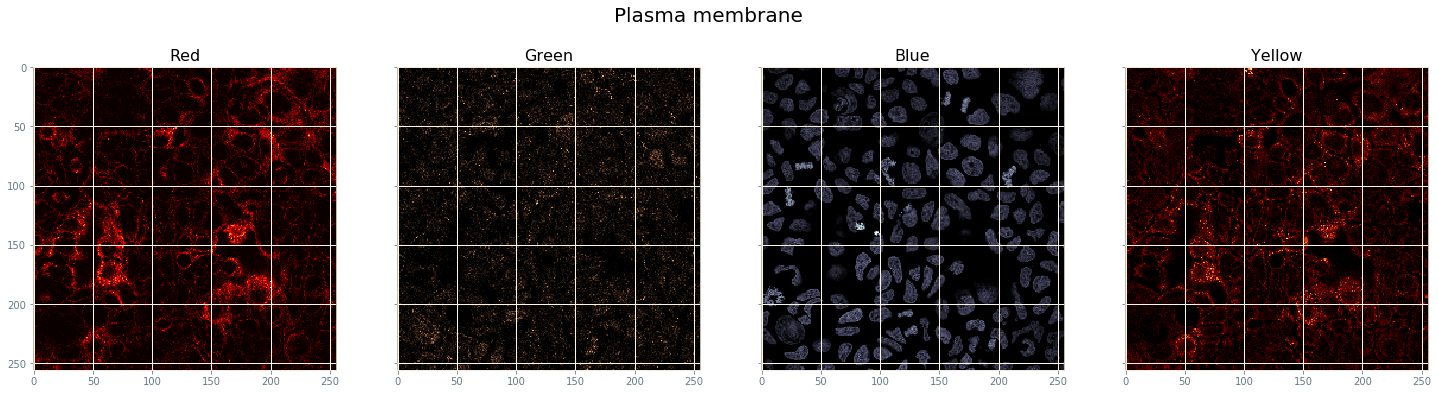

In [20]:
show(images[0], labels[0])

In [21]:
hpa_conv_neural_net = HPA_ConvNeuralNet()

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
print(device)

cuda:0


In [24]:
hpa_conv_neural_net.to(device)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [25]:
criterion=nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(hpa_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [26]:
num_of_epoch = 4
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

In [ ]:
torch.cuda.empty_cache()
since = time.time()
for epoch in range(num_of_epoch):
    epoch_train_accuracy = 0.0
    epoch_train_loss = 0.0
    correct_predicted_total = 0.0
    train_loss = 0.0
    #total_loss = 0.0
    #total = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        
        outputs = hpa_conv_neural_net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        predicted = outputs > 0

        #total += labels.size(0)
        labels = labels.data.byte()
        sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
        item = sum_of_correct_predicted.item()
        correct_predicted_total += item
        
    epoch_train_loss = train_loss / train_dataset_size
    epoch_learn_accuracy = correct_predicted_total / train_dataset_size
    
    validation_loss, validation_accuracy = validate(hpa_conv_neural_net, validation_loader, criterion)
    
    epoch_validation_loss = validation_loss / validation_dataset_size
    epoch_validation_accuracy = validation_accuracy / validation_dataset_size
    
    print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              epoch_train_loss,
              epoch_train_accuracy,
              epoch_validation_loss,
              epoch_validation_accuracy
        )
    )
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    validation_losses.append(epoch_validation_loss)
    validation_accuracies.append(epoch_validation_accuracy)
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

In [ ]:
torch.cuda.empty_cache()
validation_accuracy = validate(hpa_conv_neural_net, validation_loader, validation_dataset_size)